In [204]:
import pandas as pd 
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Adding Original Data + Simple preprocessing to make it concatenable with training set

In [127]:
original_data = pd.read_csv('original_data.csv')
original_data.drop('EmployeeNumber',axis=1,inplace=True)
original_data['Attrition'] = original_data['Attrition'].map({'Yes':1,'No':0})

In [128]:
len(original_data)

1470

In [129]:
train = pd.read_csv('train.csv')
len(train)

1677

In [205]:
# Adding original data will make the training set twice as large.

In [130]:
train = pd.read_csv('train.csv')
train.drop('id',axis=1,inplace=True)
train = pd.concat([train,original_data])
def preproces(train):
    categorical_columns = ['BusinessTravel','Department','EducationField','Gender','JobRole',
                          'MaritalStatus','Over18','OverTime']
    # Converting Categorica to dummies
    for c in categorical_columns:
        # get the dummies and store it in a variable
        dummies = pd.get_dummies(train[c])
        dummies.columns = [c+'_'+k for k in dummies.columns]
        merged = pd.concat([train, dummies], axis='columns')

        train = merged.copy()
    train.drop(categorical_columns,axis=1,inplace=True)

    return train

In [131]:
train = preproces(train)
features = [c for c in train if c not in ['id','Attrition']]
target = 'Attrition'

In [132]:
# Splitting training set - startified to get a good repartition of Attrition everywhere 
x = train[features]
y = train[target]
x_train1, x_test, y_train1, y_test = train_test_split(x, y, test_size=0.05, stratify = y)


In [207]:
# defining an xgboost regressor
# regularisation parameters were found through trial and error. can probably be improved
xg_reg = xgb.XGBRegressor(
            objective='reg:pseudohubererror',
            tree_method="hist",
            n_estimators=1000,
            learning_rate=0.0075,
            reg_lambda = 0.3,
            reg_alpha = 0.2,
            max_leaves = 17,
            subsample=0.50,
            colsample_bytree=0.50,
            max_bin=4096,
            n_jobs=2,
            eval_metric='auc',
            early_stopping_rounds=70,
        )
xg_reg.fit(x_train1,y_train1,eval_set=[(x_train1,y_train1),(x_test,y_test)],verbose=200)



[0]	validation_0-auc:0.72768	validation_1-auc:0.71441
[200]	validation_0-auc:0.91438	validation_1-auc:0.87333
[396]	validation_0-auc:0.93820	validation_1-auc:0.88001


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=70, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0075, max_bin=4096, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=17, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=2, num_parallel_tree=1, objective='reg:pseudohubererror',
             predictor='auto', random_state=0, reg_alpha=0.2, ...)

In [208]:
preds = xg_reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.298013


# Grid search to maximise ROC-AUC

In [171]:
cv_params = {'max_depth':[6,10,15],'max_leaves':[10,20,30] ,'alpha':[0.2,0.3,0.5],'lambda':[0.2,0.3,0.5],'learning_rate':[0.05,0.0075]}    # parameters to be tried in the grid search
fix_params = {'tree_method':'hist','n_estimators': 4999,'early_stopping_rounds':70 ,'objective': 'reg:pseudohubererror',
              'subsample':0.5,'colsample_bytree':0.5,'max_bin':4096,'n_jobs':2,"eval_metric":'auc'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'roc_auc', cv = 5)
csv.fit(x_train1,y_train1,eval_set=[(x_train1,y_train1),(x_test,y_test)],verbose=1000)

[0]	validation_0-auc:0.71270	validation_1-auc:0.70805
[140]	validation_0-auc:0.92794	validation_1-auc:0.85762
[0]	validation_0-auc:0.72464	validation_1-auc:0.70104
[216]	validation_0-auc:0.95286	validation_1-auc:0.87066
[0]	validation_0-auc:0.72206	validation_1-auc:0.67998
[175]	validation_0-auc:0.93927	validation_1-auc:0.85662
[0]	validation_0-auc:0.71177	validation_1-auc:0.72159
[219]	validation_0-auc:0.94537	validation_1-auc:0.87600
[0]	validation_0-auc:0.72751	validation_1-auc:0.72911
[149]	validation_0-auc:0.93194	validation_1-auc:0.86430
[0]	validation_0-auc:0.74021	validation_1-auc:0.72761
[133]	validation_0-auc:0.95551	validation_1-auc:0.85996
[0]	validation_0-auc:0.73904	validation_1-auc:0.72577
[140]	validation_0-auc:0.96776	validation_1-auc:0.85628
[0]	validation_0-auc:0.75094	validation_1-auc:0.70187
[169]	validation_0-auc:0.96054	validation_1-auc:0.85628
[0]	validation_0-auc:0.73210	validation_1-auc:0.70388
[324]	validation_0-auc:0.97332	validation_1-auc:0.88536
[0]	valida

[0]	validation_0-auc:0.71270	validation_1-auc:0.70805
[287]	validation_0-auc:0.88928	validation_1-auc:0.86965
[0]	validation_0-auc:0.72464	validation_1-auc:0.70104
[97]	validation_0-auc:0.86290	validation_1-auc:0.85795
[0]	validation_0-auc:0.72206	validation_1-auc:0.67998
[96]	validation_0-auc:0.86287	validation_1-auc:0.82721
[0]	validation_0-auc:0.71177	validation_1-auc:0.72159
[482]	validation_0-auc:0.90708	validation_1-auc:0.87333
[0]	validation_0-auc:0.72751	validation_1-auc:0.72911
[108]	validation_0-auc:0.85737	validation_1-auc:0.84158
[0]	validation_0-auc:0.74021	validation_1-auc:0.72761
[319]	validation_0-auc:0.93138	validation_1-auc:0.87901
[0]	validation_0-auc:0.73904	validation_1-auc:0.72577
[413]	validation_0-auc:0.94596	validation_1-auc:0.87801
[0]	validation_0-auc:0.75094	validation_1-auc:0.70187
[99]	validation_0-auc:0.89907	validation_1-auc:0.84325
[0]	validation_0-auc:0.73210	validation_1-auc:0.70388
[95]	validation_0-auc:0.89381	validation_1-auc:0.84459
[0]	validation

[0]	validation_0-auc:0.71210	validation_1-auc:0.70805
[131]	validation_0-auc:0.86474	validation_1-auc:0.86564
[0]	validation_0-auc:0.71119	validation_1-auc:0.69352
[96]	validation_0-auc:0.86316	validation_1-auc:0.85729
[0]	validation_0-auc:0.72780	validation_1-auc:0.72543
[97]	validation_0-auc:0.86137	validation_1-auc:0.82854
[0]	validation_0-auc:0.71177	validation_1-auc:0.72159
[485]	validation_0-auc:0.90687	validation_1-auc:0.87099
[0]	validation_0-auc:0.72772	validation_1-auc:0.72911
[114]	validation_0-auc:0.85718	validation_1-auc:0.84291
[0]	validation_0-auc:0.74021	validation_1-auc:0.72761
[206]	validation_0-auc:0.91587	validation_1-auc:0.87400
[0]	validation_0-auc:0.73595	validation_1-auc:0.73128
[409]	validation_0-auc:0.94524	validation_1-auc:0.87767
[0]	validation_0-auc:0.75094	validation_1-auc:0.70187
[99]	validation_0-auc:0.89826	validation_1-auc:0.84492
[0]	validation_0-auc:0.73210	validation_1-auc:0.70388
[430]	validation_0-auc:0.93837	validation_1-auc:0.87600
[0]	validatio

[0]	validation_0-auc:0.71200	validation_1-auc:0.70805
[285]	validation_0-auc:0.88806	validation_1-auc:0.87734
[0]	validation_0-auc:0.71119	validation_1-auc:0.69352
[389]	validation_0-auc:0.90504	validation_1-auc:0.88436
[0]	validation_0-auc:0.72780	validation_1-auc:0.72543
[96]	validation_0-auc:0.86134	validation_1-auc:0.82754
[0]	validation_0-auc:0.71177	validation_1-auc:0.72159
[518]	validation_0-auc:0.90922	validation_1-auc:0.87032
[0]	validation_0-auc:0.72772	validation_1-auc:0.72911
[104]	validation_0-auc:0.85659	validation_1-auc:0.84158
[0]	validation_0-auc:0.74021	validation_1-auc:0.72761
[205]	validation_0-auc:0.91400	validation_1-auc:0.87132
[0]	validation_0-auc:0.73595	validation_1-auc:0.73128
[185]	validation_0-auc:0.91594	validation_1-auc:0.87233
[0]	validation_0-auc:0.75216	validation_1-auc:0.71140
[99]	validation_0-auc:0.89696	validation_1-auc:0.84525
[0]	validation_0-auc:0.73325	validation_1-auc:0.70822
[433]	validation_0-auc:0.93743	validation_1-auc:0.87801
[0]	validati

[0]	validation_0-auc:0.71200	validation_1-auc:0.70805
[182]	validation_0-auc:0.93390	validation_1-auc:0.84960
[0]	validation_0-auc:0.71119	validation_1-auc:0.69352
[214]	validation_0-auc:0.95140	validation_1-auc:0.86531
[0]	validation_0-auc:0.72780	validation_1-auc:0.72543
[160]	validation_0-auc:0.93564	validation_1-auc:0.84091
[0]	validation_0-auc:0.71179	validation_1-auc:0.72193
[273]	validation_0-auc:0.95181	validation_1-auc:0.87868
[0]	validation_0-auc:0.72772	validation_1-auc:0.72911
[159]	validation_0-auc:0.93575	validation_1-auc:0.88670
[0]	validation_0-auc:0.74021	validation_1-auc:0.72761
[141]	validation_0-auc:0.95899	validation_1-auc:0.86464
[0]	validation_0-auc:0.73595	validation_1-auc:0.73128
[141]	validation_0-auc:0.96721	validation_1-auc:0.86230
[0]	validation_0-auc:0.75207	validation_1-auc:0.71140
[101]	validation_0-auc:0.94753	validation_1-auc:0.83389
[0]	validation_0-auc:0.73330	validation_1-auc:0.70822
[149]	validation_0-auc:0.96037	validation_1-auc:0.88803
[0]	valida

[0]	validation_0-auc:0.71200	validation_1-auc:0.70805
[238]	validation_0-auc:0.94452	validation_1-auc:0.85394
[0]	validation_0-auc:0.71119	validation_1-auc:0.69352
[210]	validation_0-auc:0.94848	validation_1-auc:0.86397
[0]	validation_0-auc:0.72780	validation_1-auc:0.72543
[174]	validation_0-auc:0.93752	validation_1-auc:0.83656
[0]	validation_0-auc:0.71179	validation_1-auc:0.72193
[206]	validation_0-auc:0.94270	validation_1-auc:0.87199
[0]	validation_0-auc:0.72772	validation_1-auc:0.72911
[155]	validation_0-auc:0.93312	validation_1-auc:0.87533
[0]	validation_0-auc:0.74021	validation_1-auc:0.72761
[128]	validation_0-auc:0.95418	validation_1-auc:0.85762
[0]	validation_0-auc:0.73593	validation_1-auc:0.73128
[142]	validation_0-auc:0.96640	validation_1-auc:0.85762
[0]	validation_0-auc:0.75207	validation_1-auc:0.71140
[100]	validation_0-auc:0.94640	validation_1-auc:0.84124
[0]	validation_0-auc:0.73330	validation_1-auc:0.70822
[149]	validation_0-auc:0.96042	validation_1-auc:0.87667
[0]	valida

[0]	validation_0-auc:0.71200	validation_1-auc:0.70805
[172]	validation_0-auc:0.93129	validation_1-auc:0.85328
[0]	validation_0-auc:0.71119	validation_1-auc:0.69352
[207]	validation_0-auc:0.95015	validation_1-auc:0.86798
[0]	validation_0-auc:0.72783	validation_1-auc:0.72543
[176]	validation_0-auc:0.93705	validation_1-auc:0.83489
[0]	validation_0-auc:0.71179	validation_1-auc:0.72193
[207]	validation_0-auc:0.94096	validation_1-auc:0.87734
[0]	validation_0-auc:0.72807	validation_1-auc:0.72861
[158]	validation_0-auc:0.93299	validation_1-auc:0.86965
[0]	validation_0-auc:0.72739	validation_1-auc:0.71441
[144]	validation_0-auc:0.95611	validation_1-auc:0.87233
[0]	validation_0-auc:0.73619	validation_1-auc:0.73128
[135]	validation_0-auc:0.96434	validation_1-auc:0.86096
[0]	validation_0-auc:0.75202	validation_1-auc:0.71374
[117]	validation_0-auc:0.94848	validation_1-auc:0.83957
[0]	validation_0-auc:0.73330	validation_1-auc:0.70822
[131]	validation_0-auc:0.95654	validation_1-auc:0.86430
[0]	valida

[0]	validation_0-auc:0.71200	validation_1-auc:0.70805
[120]	validation_0-auc:0.86078	validation_1-auc:0.86230
[0]	validation_0-auc:0.71119	validation_1-auc:0.69352
[387]	validation_0-auc:0.90320	validation_1-auc:0.88202
[0]	validation_0-auc:0.72783	validation_1-auc:0.72543
[97]	validation_0-auc:0.86129	validation_1-auc:0.83021
[0]	validation_0-auc:0.71179	validation_1-auc:0.72193
[423]	validation_0-auc:0.90068	validation_1-auc:0.87233
[0]	validation_0-auc:0.72807	validation_1-auc:0.72861
[103]	validation_0-auc:0.85583	validation_1-auc:0.84057
[0]	validation_0-auc:0.72739	validation_1-auc:0.71441
[211]	validation_0-auc:0.91275	validation_1-auc:0.87467
[0]	validation_0-auc:0.73619	validation_1-auc:0.73128
[414]	validation_0-auc:0.94235	validation_1-auc:0.88269
[0]	validation_0-auc:0.75202	validation_1-auc:0.71374
[484]	validation_0-auc:0.94408	validation_1-auc:0.87801
[0]	validation_0-auc:0.73330	validation_1-auc:0.70822
[283]	validation_0-auc:0.91956	validation_1-auc:0.87467
[0]	validat

[0]	validation_0-auc:0.71194	validation_1-auc:0.70772
[122]	validation_0-auc:0.85963	validation_1-auc:0.86063
[0]	validation_0-auc:0.71268	validation_1-auc:0.70271
[446]	validation_0-auc:0.90765	validation_1-auc:0.87634
[0]	validation_0-auc:0.71183	validation_1-auc:0.71691
[96]	validation_0-auc:0.86014	validation_1-auc:0.82787
[0]	validation_0-auc:0.71145	validation_1-auc:0.72293
[425]	validation_0-auc:0.90052	validation_1-auc:0.87233
[0]	validation_0-auc:0.72807	validation_1-auc:0.72861
[215]	validation_0-auc:0.87450	validation_1-auc:0.84693
[0]	validation_0-auc:0.72877	validation_1-auc:0.71307
[262]	validation_0-auc:0.91845	validation_1-auc:0.87333
[0]	validation_0-auc:0.73406	validation_1-auc:0.68733
[125]	validation_0-auc:0.90163	validation_1-auc:0.86430
[0]	validation_0-auc:0.73132	validation_1-auc:0.72076
[108]	validation_0-auc:0.89545	validation_1-auc:0.84291
[0]	validation_0-auc:0.72909	validation_1-auc:0.70889
[437]	validation_0-auc:0.93480	validation_1-auc:0.87934
[0]	validat

[0]	validation_0-auc:0.71194	validation_1-auc:0.70772
[120]	validation_0-auc:0.85949	validation_1-auc:0.85829
[0]	validation_0-auc:0.71268	validation_1-auc:0.70271
[428]	validation_0-auc:0.90575	validation_1-auc:0.87734
[0]	validation_0-auc:0.71183	validation_1-auc:0.71691
[97]	validation_0-auc:0.85991	validation_1-auc:0.82821
[0]	validation_0-auc:0.71145	validation_1-auc:0.72293
[425]	validation_0-auc:0.90021	validation_1-auc:0.87166
[0]	validation_0-auc:0.72807	validation_1-auc:0.72861
[215]	validation_0-auc:0.87426	validation_1-auc:0.84860
[0]	validation_0-auc:0.72877	validation_1-auc:0.71307
[262]	validation_0-auc:0.91796	validation_1-auc:0.87066
[0]	validation_0-auc:0.73406	validation_1-auc:0.68733
[317]	validation_0-auc:0.93046	validation_1-auc:0.88369
[0]	validation_0-auc:0.73132	validation_1-auc:0.72076
[109]	validation_0-auc:0.89451	validation_1-auc:0.84258
[0]	validation_0-auc:0.72978	validation_1-auc:0.71023
[196]	validation_0-auc:0.90639	validation_1-auc:0.86364
[0]	validat

[0]	validation_0-auc:0.71194	validation_1-auc:0.70772
[182]	validation_0-auc:0.93360	validation_1-auc:0.84258
[0]	validation_0-auc:0.71261	validation_1-auc:0.70271
[226]	validation_0-auc:0.95062	validation_1-auc:0.86932
[0]	validation_0-auc:0.71183	validation_1-auc:0.71691
[144]	validation_0-auc:0.92912	validation_1-auc:0.85294
[0]	validation_0-auc:0.71145	validation_1-auc:0.72293
[185]	validation_0-auc:0.93759	validation_1-auc:0.88269
[0]	validation_0-auc:0.72807	validation_1-auc:0.72861
[153]	validation_0-auc:0.92961	validation_1-auc:0.87299
[0]	validation_0-auc:0.72877	validation_1-auc:0.71307
[141]	validation_0-auc:0.95453	validation_1-auc:0.86029
[0]	validation_0-auc:0.72265	validation_1-auc:0.70939
[130]	validation_0-auc:0.96266	validation_1-auc:0.85027
[0]	validation_0-auc:0.72509	validation_1-auc:0.70605
[98]	validation_0-auc:0.94235	validation_1-auc:0.85628
[0]	validation_0-auc:0.72985	validation_1-auc:0.71056
[130]	validation_0-auc:0.95367	validation_1-auc:0.88001
[0]	validat

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.5,
                                    early_stopping_rounds=70,
                                    enable_categorical=False, eval_metric='auc',
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=4096,
                                    max_cat_t...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=4999, n_jobs=2,
                                    num_parallel_tree=None,
                                    objective='reg:pseudohubererror',
                                    predictor=None, random_state=None,
                                    reg_alpha=None, ...),
             param_grid={'alpha': [0.2, 0.3, 0.5], 'lambda': [0.2, 0.3, 0.5],
                         'learning_rate': [0.05, 0.0075],
                         'max_depth': [6, 10, 15], 'max_leaves': [10, 20, 30]},
             scoring='roc_auc')

In [172]:
csv.best_params_

{'alpha': 0.3,
 'lambda': 0.2,
 'learning_rate': 0.05,
 'max_depth': 6,
 'max_leaves': 10}

In [173]:
fix_params['learning_rate'] = 0.005
fix_params['max_depth'] = 10

In [174]:
csv.best_score_

0.8460906332075906

In [102]:
csv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=70, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=4096, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=4999,
             n_jobs=2, num_parallel_tree=1, objective='reg:pseudohubererror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [103]:
xgdmat_train = xgb.DMatrix(x_train1, y_train1)
xgdmat_test = xgb.DMatrix(x_test, y_test)
params_final = fix_params

xg_reg = xgb.XGBRegressor(**params_final,
        )
xg_reg.fit(x_train1,y_train1,eval_set=[(x_train1,y_train1),(x_test,y_test)],verbose=200)

[0]	validation_0-auc:0.93430	validation_1-auc:0.71374
[71]	validation_0-auc:0.98194	validation_1-auc:0.74215


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=70, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.005, max_bin=4096, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=4999,
             n_jobs=2, num_parallel_tree=1, objective='reg:pseudohubererror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

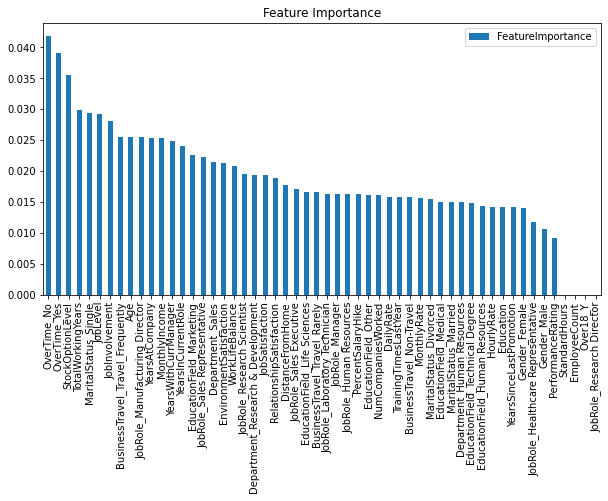

In [177]:
fi =pd.DataFrame(data=xg_reg.feature_importances_,index=xg_reg.feature_names_in_,columns=['FeatureImportance']).sort_values(by='FeatureImportance',ascending=False)
fi.plot.bar(title='Feature Importance',figsize=(10,5))
plt.show()

# Getting a prediction

In [179]:
test = pd.read_csv('test.csv')

In [180]:
test_processed = preproces(test)

In [181]:
predictions = xg_reg.predict(test_processed[features])
test_processed['Attrition'] = predictions
submission = test_processed[['id','Attrition']]

In [183]:
submission.to_csv('MyPrediction.csv',index=None)